In [1]:
## import statements ##

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, BayesianRidge, QuantileRegressor
from sklearn.tree import DecisionTreeRegressor,plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression, SelectFromModel
from sklearn.svm import SVR


In [2]:
## load data ##

data_rain = pd.read_csv('data_mrc/Rainfall_StungTreng.csv')
data_flow = pd.read_csv('data_mrc/Discharge_StungTreng.csv')
data_flow_kratie = pd.read_csv('data_mrc/Discharge_Kratie.csv')
data_gdp = pd.read_csv('data_imf/thailand_gdp_imf.csv', delimiter=';')
data_rice = pd.read_csv('data_fao/rice_prod.csv')
data_rain_ck = pd.read_csv('data_mrc/Rainfall_ChiangKhan.csv')
data_flow_ck = pd.read_csv('data_mrc/Discharge_ChiangKhan.csv')
data_iea = pd.read_csv('data_iea/cambodia_renewable.csv')

# rename columns for unique identification
data_rain = data_rain.rename(columns={'Value': 'rainfall'})
data_rain_ck = data_rain_ck.rename(columns={'Value': 'rainfall_ck'})
data_flow_ck = data_flow_ck.rename(columns={'Value': 'flowrate_ck'})
data_flow = data_flow.rename(columns={'Value': 'flowrate'})
data_flow_kratie = data_flow_kratie.rename(columns={'Value': 'flowrate_kratie'})
data_gdp = data_gdp.rename(columns={'GDP (Billions of U.S. dollars)': 'gdp'})
data_rice = data_rice.rename(columns={'production (t)': 'rice'})
data_iea = data_iea.rename(columns={'generation (GWh)': 'elec'})

data_rain = data_rain[['Timestamp (UTC+07:00)', 'rainfall']]
data_flow = data_flow[['Timestamp (UTC+07:00)', 'flowrate']]
data_flow_kratie = data_flow_kratie[['Timestamp (UTC+07:00)', 'flowrate_kratie']]
data_rain_ck = data_rain_ck[['Timestamp (UTC+07:00)', 'rainfall_ck']]
data_flow_ck = data_flow_ck[['Timestamp (UTC+07:00)', 'flowrate_ck']]
data_rice = data_rice[data_rice['country']=='Cambodia'][['year', 'rice']]
data_iea = data_iea[data_iea['source']=='hydro'][['year', 'elec']]

# merge data
df = pd.merge(data_rain, data_flow, on='Timestamp (UTC+07:00)', how='inner')
df = pd.merge(df, data_rain_ck, on='Timestamp (UTC+07:00)', how='inner')
df = pd.merge(df, data_flow_ck, on='Timestamp (UTC+07:00)', how='inner')
df = pd.merge(df, data_flow_kratie, on='Timestamp (UTC+07:00)', how='inner')

df['Timestamp (UTC+07:00)'] = pd.to_datetime(df['Timestamp (UTC+07:00)'], format='%Y-%m-%dT%H:%M%z')
df = df.rename(columns={'Timestamp (UTC+07:00)': 'date'})
df.set_index('date', inplace=True)

# Calculate the minimum flowrate over the past week / month (base flowrate)
df['min_flow_week'] = df['flowrate'].rolling(window=7, min_periods=1).min()
df['min_flow_month'] = df['flowrate'].rolling(window=30, min_periods=1).min()

df['min_flow_month_ck'] = df['flowrate_ck'].rolling(window=30, min_periods=1).min()

# add lag rainfall features
df['rainfall_lag1'] = df['rainfall'].shift(1)
df['rainfall_lag2'] = df['rainfall'].shift(2)
df['rainfall_lag3'] = df['rainfall'].shift(3)
df['rainfall_lag5weeks'] = df['rainfall'].shift(35)
df['rainfall_week'] = df['rainfall'].rolling(window=7, min_periods=1).sum()
df['rainfall_5weeks'] = df['rainfall'].rolling(window=35, min_periods=1).sum()

df['rainfall_lag1_ck'] = df['rainfall_ck'].shift(1)
df['rainfall_lag2_ck'] = df['rainfall_ck'].shift(2)
df['rainfall_lag3_ck'] = df['rainfall_ck'].shift(3)
df['rainfall_lag5weeks_ck'] = df['rainfall_ck'].shift(35)
df['rainfall_week_ck'] = df['rainfall_ck'].rolling(window=7, min_periods=1).sum()
df['rainfall_5weeks_ck'] = df['rainfall_ck'].rolling(window=35, min_periods=1).sum()

# extract DateTime components
df['year'] = df.index.year
df['month'] = df.index.month
df['week_of_year'] = df.index.isocalendar().week.astype(int)

# merge with gdp data
df = pd.merge(df, data_gdp, on='year', how='left')
df = pd.merge(df, data_rice, on='year', how='left')
df = pd.merge(df, data_iea, on='year', how='left')

# scale data
scaler_rain = StandardScaler()
df[['rainfall', 'rainfall_lag1','rainfall_lag2','rainfall_lag3', 'rainfall_lag5weeks' ,'rainfall_week', 'rainfall_5weeks', 'rainfall_ck', 'rainfall_lag1_ck','rainfall_lag2_ck','rainfall_lag3_ck', 'rainfall_lag5weeks_ck' ,'rainfall_week_ck', 'rainfall_5weeks_ck']] \
    = scaler_rain.fit_transform(df[['rainfall', 'rainfall_lag1','rainfall_lag2','rainfall_lag3', 'rainfall_lag5weeks' ,'rainfall_week', 'rainfall_5weeks', 'rainfall_ck', 'rainfall_lag1_ck','rainfall_lag2_ck','rainfall_lag3_ck', 'rainfall_lag5weeks_ck' ,'rainfall_week_ck', 'rainfall_5weeks_ck']])
scaler_flow = StandardScaler()
df[['flowrate', 'min_flow_week','min_flow_month']] = scaler_flow.fit_transform(df[['flowrate', 'min_flow_week','min_flow_month']])
scaler_flow_ck = StandardScaler()
df[['flowrate_ck','min_flow_month_ck']] = scaler_flow_ck.fit_transform(df[['flowrate_ck', 'min_flow_month_ck']])
scaler_flow_kratie = StandardScaler()
df[['flowrate_kratie']] = scaler_flow_kratie.fit_transform(df[['flowrate_kratie']])
scaler_gdp = StandardScaler()
df[['gdp']] = scaler_gdp.fit_transform(df[['gdp']])
scaler_rice = StandardScaler()
df[['rice']] = scaler_rice.fit_transform(df[['rice']])
scaler_elec = StandardScaler()
df[['elec']] = scaler_elec.fit_transform(df[['elec']])


In [3]:
# drop rows with missing values
df.dropna(inplace=True)
df.head()

,rainfall,flowrate,rainfall_ck,flowrate_ck,flowrate_kratie,min_flow_week,min_flow_month,min_flow_month_ck,rainfall_lag1,rainfall_lag2,...,rainfall_lag3_ck,rainfall_lag5weeks_ck,rainfall_week_ck,rainfall_5weeks_ck,year,month,week_of_year,gdp,rice,elec
35,0.326446,1.570600,2.881608,3.027730,1.471277,1.532677,-0.104346,-0.482993,1.383120,0.551179,...,0.853895,0.364932,2.892454,1.389288,2008,9,38,-2.340008,-2.634104,-1.332055
36,3.442575,1.908815,0.483043,3.101763,1.693867,1.532677,0.038560,-0.482993,0.326326,1.382901,...,0.083158,-0.308539,3.117389,1.459783,2008,9,38,-2.340008,-2.634104,-1.332055
37,2.392501,2.155112,-0.278406,2.580281,1.928172,1.532677,0.073638,-0.475934,3.442164,0.326205,...,2.861618,-0.156771,2.466977,1.448742,2008,9,38,-2.340008,-2.634104,-1.332055
38,0.299171,2.200480,1.311119,2.232842,2.122539,1.532677,0.747354,0.844627,2.392188,3.441752,...,2.880648,-0.213684,2.334184,1.584637,2008,9,38,-2.340008,-2.634104,-1.332055
39,-0.082674,1.964366,0.045209,1.862673,2.060590,1.568056,0.747354,0.999927,0.299053,2.391874,...,0.482799,-0.005003,2.103830,1.588884,2008,9,38,-2.340008,-2.634104,-1.332055


In [4]:
df.describe()

,rainfall,flowrate,rainfall_ck,flowrate_ck,flowrate_kratie,min_flow_week,min_flow_month,min_flow_month_ck,rainfall_lag1,rainfall_lag2,...,rainfall_lag3_ck,rainfall_lag5weeks_ck,rainfall_week_ck,rainfall_5weeks_ck,year,month,week_of_year,gdp,rice,elec
count,4027.000000,4027.000000,4027.000000,4027.000000,4027.000000,4027.000000,4027.000000,4027.000000,4027.000000,4027.000000,...,4027.000000,4027.000000,4027.000000,4027.000000,4027.000000,4027.000000,4027.000000,4027.000000,4027.000000,4027.000000
mean,-0.034723,-0.008751,-0.011956,0.003276,-0.008842,-0.002437,0.012184,0.031481,-0.034408,-0.034275,...,-0.010844,-0.013513,-0.021021,-0.028425,2015.173082,6.636702,27.049665,-0.107434,-0.030015,0.011577
std,0.956529,1.002105,0.976027,0.986254,1.000603,1.007664,1.012562,1.014662,0.956695,0.956639,...,0.976837,0.969861,0.991670,1.001868,3.258843,3.365671,14.680164,0.942478,0.942636,0.996686
min,-0.403151,-0.982832,-0.354551,-1.169136,-0.949537,-0.976754,-0.949221,-1.155627,-0.403203,-0.403256,...,-0.354545,-0.355966,-0.706492,-1.106937,2008.000000,1.000000,1.000000,-2.490841,-2.634104,-1.339751
25%,-0.403151,-0.726417,-0.354551,-0.690339,-0.727338,-0.710262,-0.651179,-0.683840,-0.403203,-0.403256,...,-0.354545,-0.355966,-0.706492,-0.892902,2012.000000,4.000000,15.000000,-0.684229,-0.570903,-1.043744
50%,-0.403151,-0.517217,-0.354551,-0.309551,-0.529726,-0.503542,-0.458674,-0.319144,-0.403203,-0.403256,...,-0.354545,-0.355966,-0.443617,-0.238906,2015.000000,7.000000,27.000000,-0.437707,-0.474291,-0.146842
75%,-0.232684,0.488722,-0.221298,0.379903,0.483213,0.460989,0.422531,0.385229,-0.232753,-0.232821,...,-0.221331,-0.213684,0.263706,0.566273,2018.000000,10.000000,40.000000,0.920539,0.984455,1.051987
max,9.852118,3.928909,12.209362,4.888787,3.333750,4.056138,4.282387,4.213340,9.851108,9.850099,...,12.205616,12.164892,7.813905,4.360296,2021.000000,12.000000,53.000000,1.599147,2.273109,1.791412


In [5]:
# Define features and target variable to separate COVID years from non-COVID years data
X_train = df[df['year'] < 2020][['rainfall', 'year', 'month', 'week_of_year', 'rainfall_lag1', 'rainfall_lag2', 'rainfall_lag3', 'rainfall_lag5weeks', 'rainfall_week', 'rainfall_5weeks', 'min_flow_month', 'rice', 'elec']]
y_train = df[df['year'] < 2020]['flowrate']
X_test = df[df['year'] >= 2020][['rainfall', 'year', 'month', 'week_of_year', 'rainfall_lag1', 'rainfall_lag2', 'rainfall_lag3', 'rainfall_lag5weeks', 'rainfall_week', 'rainfall_5weeks', 'min_flow_month', 'rice', 'elec']]
y_test = df[df['year'] >= 2020]['flowrate']

In [6]:
lasso_model = Lasso()

# Define the hyperparameter grid for Lasso
param_grid = {
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
}

# Set up nested cross-validation
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store results
outer_cv_mse_scores = []
outer_cv_r2_scores = []

# Perform nested cross-validation
for train_idx, val_idx in outer_cv.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Perform hyperparameter tuning using GridSearchCV within the training data
    grid_search = GridSearchCV(lasso_model, param_grid, cv=inner_cv, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train_fold, y_train_fold)

    # Get the best model from the grid search
    best_model = grid_search.best_estimator_

    # Evaluate the best model on the validation data
    y_pred = best_model.predict(X_val_fold)
    mse_score = mean_squared_error(y_val_fold, y_pred)
    r2_score_value = r2_score(y_val_fold, y_pred)

    # Store the results
    outer_cv_mse_scores.append(mse_score)
    outer_cv_r2_scores.append(r2_score_value)

# Calculate the mean and standard deviation of the scores
mean_mse = np.mean(outer_cv_mse_scores)
std_mse = np.std(outer_cv_mse_scores)
mean_r2 = np.mean(outer_cv_r2_scores)
std_r2 = np.std(outer_cv_r2_scores)

# Print cross-validation results
print("Lasso Regression Model")
print(f"Mean Cross-Validation MSE: {mean_mse:.4f} ± {std_mse:.4f}")
print(f"Mean Cross-Validation R²: {mean_r2:.4f} ± {std_r2:.4f}")

Lasso Regression Model
Mean Cross-Validation MSE: 0.1884 ± 0.0172
Mean Cross-Validation R²: 0.8225 ± 0.0153


In [7]:
dt_model = DecisionTreeRegressor(random_state=42)

# Define the hyperparameter grid for Decision Tree
param_grid = {
    'max_depth': [None, 5, 7, 9, 10, 11],
    'min_samples_split': [10, 15, 17, 19, 21],
    'min_samples_leaf': [2, 3, 4, 5, 6, 7],
    'max_features': [None, 6, 7, 8, 9]
}

# Set up nested cross-validation
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = KFold(n_splits=2, shuffle=True, random_state=42)

# Initialize lists to store results
outer_cv_mse_scores = []
outer_cv_r2_scores = []

# Perform nested cross-validation
for train_idx, val_idx in outer_cv.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Perform hyperparameter tuning using GridSearchCV within the training data
    grid_search = GridSearchCV(dt_model, param_grid, cv=inner_cv, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train_fold, y_train_fold)

    # Get the best model from the grid search
    best_model = grid_search.best_estimator_

    # Evaluate the best model on the validation data
    y_pred = best_model.predict(X_val_fold)
    mse_score = mean_squared_error(y_val_fold, y_pred)
    r2_score_value = r2_score(y_val_fold, y_pred)

    # Store the results
    outer_cv_mse_scores.append(mse_score)
    outer_cv_r2_scores.append(r2_score_value)

# Calculate the mean and standard deviation of the scores
mean_mse = np.mean(outer_cv_mse_scores)
std_mse = np.std(outer_cv_mse_scores)
mean_r2 = np.mean(outer_cv_r2_scores)
std_r2 = np.std(outer_cv_r2_scores)

# Print cross-validation results
print("Decision Tree Regressor Model")
print(f"Mean Cross-Validation MSE: {mean_mse:.4f} ± {std_mse:.4f}")
print(f"Mean Cross-Validation R²: {mean_r2:.4f} ± {std_r2:.4f}")

Decision Tree Regressor Model
Mean Cross-Validation MSE: 0.0598 ± 0.0153
Mean Cross-Validation R²: 0.9440 ± 0.0131


In [8]:
rf_model = RandomForestRegressor(random_state=42)

# Define the hyperparameter grid for RandomForest regression
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [10, 15, 20],
    'min_samples_leaf': [2, 4, 6],
    'max_features': [6, 7, 8, 9]
}

# Set up nested cross-validation
outer_cv = KFold(n_splits=3, shuffle=True, random_state=42)
inner_cv = KFold(n_splits=2, shuffle=True, random_state=42)

# Initialize lists to store results
outer_cv_mse_scores = []
outer_cv_r2_scores = []

# Perform nested cross-validation
for train_idx, val_idx in outer_cv.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Perform hyperparameter tuning using GridSearchCV within the training data
    grid_search = GridSearchCV(rf_model, param_grid, cv=inner_cv, scoring='neg_mean_squared_error', n_jobs=-1, error_score='raise')
    grid_search.fit(X_train_fold, y_train_fold)

    # Get the best model from the grid search
    best_model = grid_search.best_estimator_
    print(best_model.get_params())

    # Evaluate the best model on the validation data
    y_pred = best_model.predict(X_val_fold)
    mse_score = mean_squared_error(y_val_fold, y_pred)
    r2_score_value = r2_score(y_val_fold, y_pred)

    # Store the results
    outer_cv_mse_scores.append(mse_score)
    outer_cv_r2_scores.append(r2_score_value)

# Calculate the mean and standard deviation of the scores
mean_mse = np.mean(outer_cv_mse_scores)
std_mse = np.std(outer_cv_mse_scores)
mean_r2 = np.mean(outer_cv_r2_scores)
std_r2 = np.std(outer_cv_r2_scores)

# Print cross-validation results
print("Random Forest Regression Model")
print(f"Mean Cross-Validation MSE: {mean_mse:.4f} ± {std_mse:.4f}")
print(f"Mean Cross-Validation R²: {mean_r2:.4f} ± {std_r2:.4f}")


{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 7, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 10, 'max_features': 8, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 20, 'max_features': 7, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 10, 'min_weight_fraction_leaf':

## Evaluate models on test set

{'alpha': 0.001, 'copy_X': True, 'fit_intercept': True, 'max_iter': 1000, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}

Lasso Regression: COVID years (2020-2021)
Test MSE: 0.2139
Test R²: 0.5776


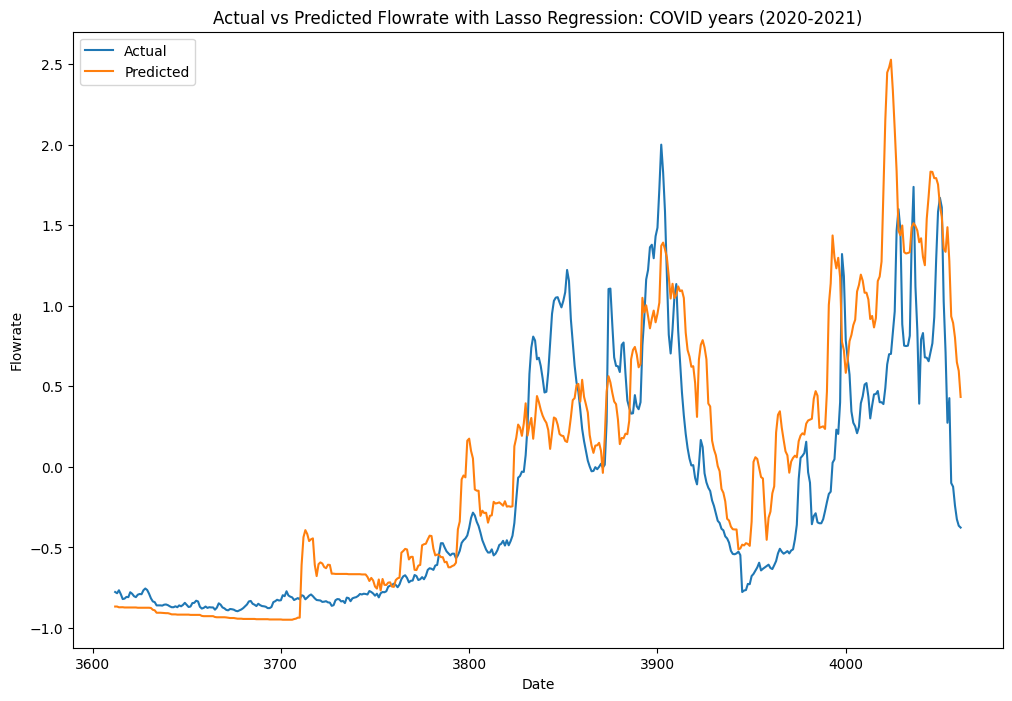

In [9]:
lasso_model = Lasso()

param_grid = {'alpha': [0.001, 0.01, 0.1, 1.0, 10.0]}
grid_search = GridSearchCV(lasso_model, param_grid, cv=inner_cv, scoring='neg_mean_squared_error', n_jobs=-1, error_score='raise')
grid_search.fit(X_train, y_train)

# Get the best model from the grid search
best_model = grid_search.best_estimator_
print(best_model.get_params())

# Evaluate the best model on the held-out test set
y_pred_lasso = best_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_pred_lasso)
test_r2 = r2_score(y_test, y_pred_lasso)

# Print test set evaluation
print("\nLasso Regression: COVID years (2020-2021)")
print(f"Test MSE: {test_mse:.4f}")
print(f"Test R²: {test_r2:.4f}")

# plot actual vs predicted
plt.figure(figsize=(12, 8))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred_lasso, label='Predicted')
plt.title('Actual vs Predicted Flowrate with Lasso Regression: COVID years (2020-2021)')
plt.xlabel('Date')
plt.ylabel('Flowrate')
plt.legend()
plt.show()

{'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 9, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 6, 'min_samples_split': 16, 'min_weight_fraction_leaf': 0.0, 'random_state': 42, 'splitter': 'best'}

Decision Tree Regression: COVID years (2020-2021)
Test MSE: 0.5298
Test R-squared: -0.0461

Feature Importances:
               Feature  Importance
3         week_of_year    0.463317
9      rainfall_5weeks    0.326006
10      min_flow_month    0.158345
1                 year    0.015212
8        rainfall_week    0.012629
12                elec    0.009519
2                month    0.009191
11                rice    0.003288
5        rainfall_lag2    0.001154
0             rainfall    0.000582
4        rainfall_lag1    0.000313
6        rainfall_lag3    0.000232
7   rainfall_lag5weeks    0.000212


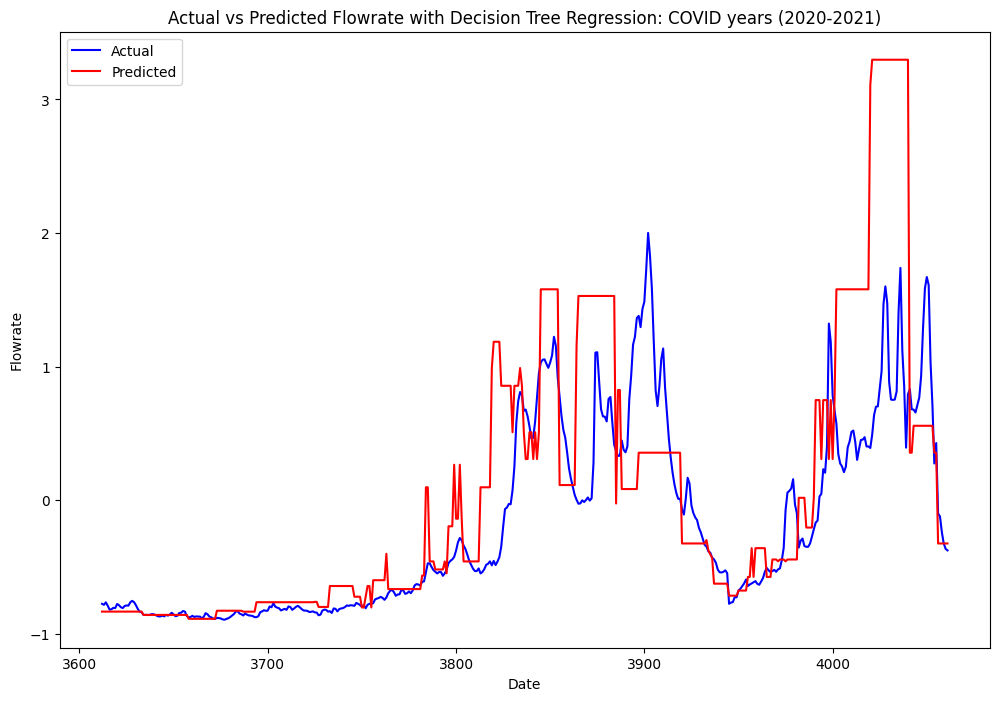

In [11]:
dt_model = DecisionTreeRegressor(random_state=42)

# Define the hyperparameter grid for Decision Tree
param_grid = {
    'max_depth': [None, 5, 7, 9, 10, 11],
    'min_samples_split': [10, 13, 14, 15, 16, 17, 19, 21],
    'criterion': ['squared_error', 'absolute_error'],
    'min_samples_leaf': [2, 3, 4, 5, 6, 7],
    'max_features': [None, 6, 7, 8, 9]
}

grid_search = GridSearchCV(dt_model, param_grid, cv=inner_cv, scoring='neg_mean_squared_error', n_jobs=-1, error_score='raise')
grid_search.fit(X_train, y_train)

# Get the best model from the grid search
best_model = grid_search.best_estimator_
print(best_model.get_params())

# Evaluate the best model on the held-out test set
y_test_pred_dt = best_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred_dt)
test_r2 = r2_score(y_test, y_test_pred_dt)

# Print test set evaluation
print("\nDecision Tree Regression: COVID years (2020-2021)")
print(f"Test MSE: {test_mse:.4f}")
print(f"Test R-squared: {test_r2:.4f}")

# Print the feature importances
feature_importances = best_model.feature_importances_
features = X_train.columns
importances = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importances = importances.sort_values('Importance', ascending=False)
print("\nFeature Importances:")
print(importances)

# plot actual vs predicted
plt.figure(figsize=(12, 8))
plt.plot(y_test.index, y_test, label='Actual', color='blue')
plt.plot(y_test.index, y_test_pred_dt, label='Predicted', color='red')
plt.title('Actual vs Predicted Flowrate with Decision Tree Regression: COVID years (2020-2021)')
plt.xlabel('Date')
plt.ylabel('Flowrate')
plt.legend()
plt.show()


Random Forest Regression: COVID years (2020-2021)
Test MSE: 0.3064
Test R-squared: 0.3951

Feature Importances:
               Feature  Importance
10      min_flow_month    0.432842
9      rainfall_5weeks    0.265334
3         week_of_year    0.123003
2                month    0.066811
8        rainfall_week    0.052012
11                rice    0.015758
1                 year    0.013228
12                elec    0.012331
6        rainfall_lag3    0.004501
5        rainfall_lag2    0.004036
4        rainfall_lag1    0.004032
0             rainfall    0.003225
7   rainfall_lag5weeks    0.002886


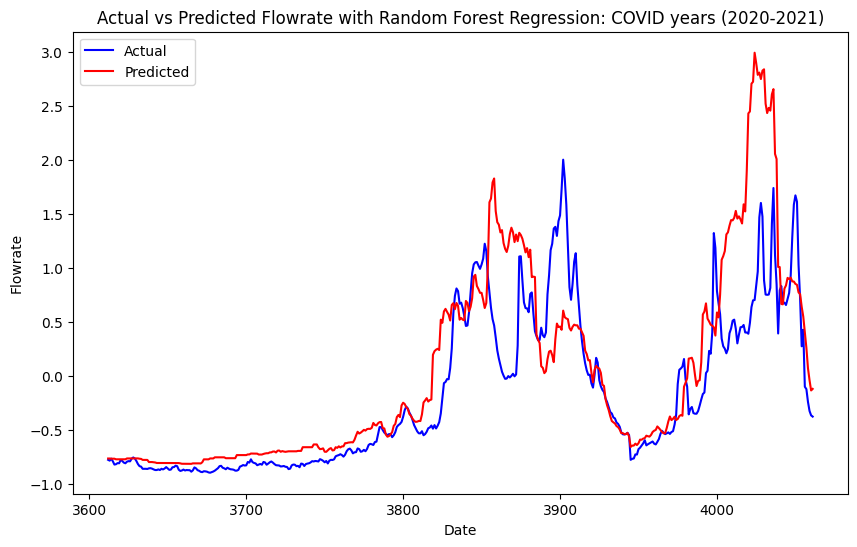

In [12]:
# Train the best model on the entire training set
rf_model = RandomForestRegressor(random_state=42)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [6, 7, 8, 9]
}
grid_search = GridSearchCV(rf_model, param_grid, cv=inner_cv, scoring='neg_mean_squared_error', n_jobs=-1, error_score='raise')
grid_search.fit(X_train, y_train)

# Get the best model from the grid search
best_model = grid_search.best_estimator_

# Evaluate the best model on the held-out test set
y_test_pred_rf = best_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred_rf)
test_r2 = r2_score(y_test, y_test_pred_rf)

# Print test set evaluation
print("\nRandom Forest Regression: COVID years (2020-2021)")
print(f"Test MSE: {test_mse:.4f}")
print(f"Test R-squared: {test_r2:.4f}")

# Print the feature importances
feature_importances = best_model.feature_importances_
features = X_train.columns
importances = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importances = importances.sort_values('Importance', ascending=False)
print("\nFeature Importances:")
print(importances)

# plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual', color='blue')
plt.plot(y_test.index, y_test_pred_rf, label='Predicted', color='red')
plt.title('Actual vs Predicted Flowrate with Random Forest Regression: COVID years (2020-2021)')
plt.xlabel('Date')
plt.ylabel('Flowrate')
plt.legend()
plt.show()